## 0.1 Import Libraries and Data series

In [19]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

#### I have decided to also use the Federal Reserve Economic Data as it has som interesting variables that relate well to the World Happiness Report, such as unemployment, Disposable income and Real Median Household Income in the United States

In [20]:
# Configure API key

quandl.ApiConfig.api_key = 'B8c-6tXeBNaB_6pnPWqk'

In [64]:
data = quandl.get('FRED/UNEMPLOY')

## 0.2 Data Checks for Unemployed

In [65]:
data.head()

Value
Date              
1948-01-01  2034.0
1948-02-01  2328.0
1948-03-01  2399.0
1948-04-01  2386.0
1948-05-01  2118.0

In [66]:
data.shape

(889, 1)

In [67]:
data.columns

Index(['Value'], dtype='object')

In [68]:
type(data)

pandas.core.frame.DataFrame

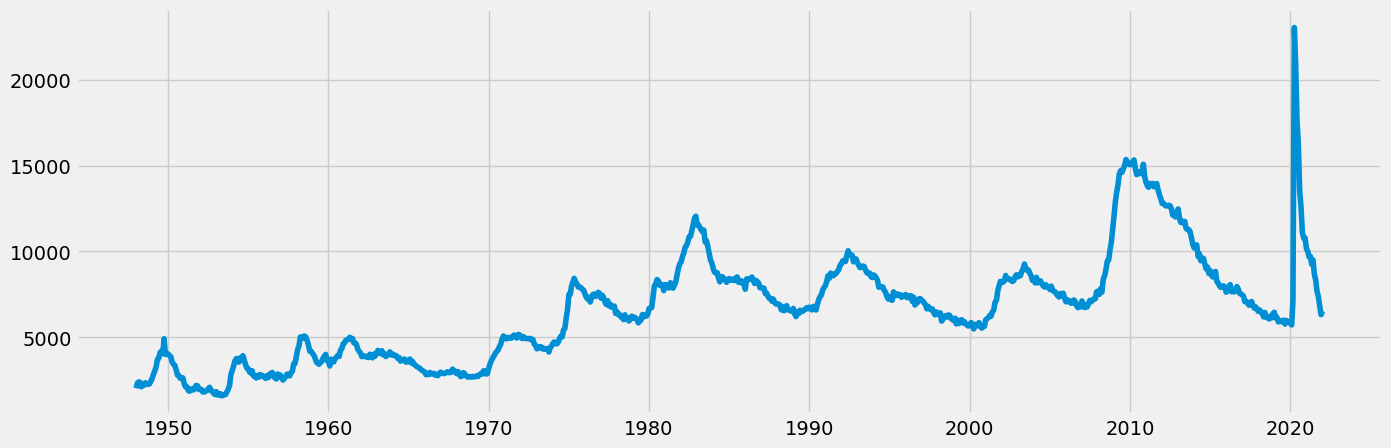

In [69]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
    

plt.plot(data)

## 0.3 Subsetting, Cleaning and wrangling the time series for Unemployed

In [70]:
# Reset index so that you can use the \"Date\" column as a filter

data_2 = data.reset_index()

In [71]:
data_2.head()

Date   Value
0 1948-01-01  2034.0
1 1948-02-01  2328.0
2 1948-03-01  2399.0
3 1948-04-01  2386.0
4 1948-05-01  2118.0

In [72]:
data_sub = data_2.loc[(data_2['Date'] >= '2000-01-01')]

In [73]:
data_sub.shape

(265, 2)

In [74]:
data_sub.head()


Date   Value
624 2000-01-01  5708.0
625 2000-02-01  5858.0
626 2000-03-01  5733.0
627 2000-04-01  5481.0
628 2000-05-01  5758.0

In [75]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

Value
datetime          
2000-01-01  5708.0
2000-02-01  5858.0
2000-03-01  5733.0
2000-04-01  5481.0
2000-05-01  5758.0

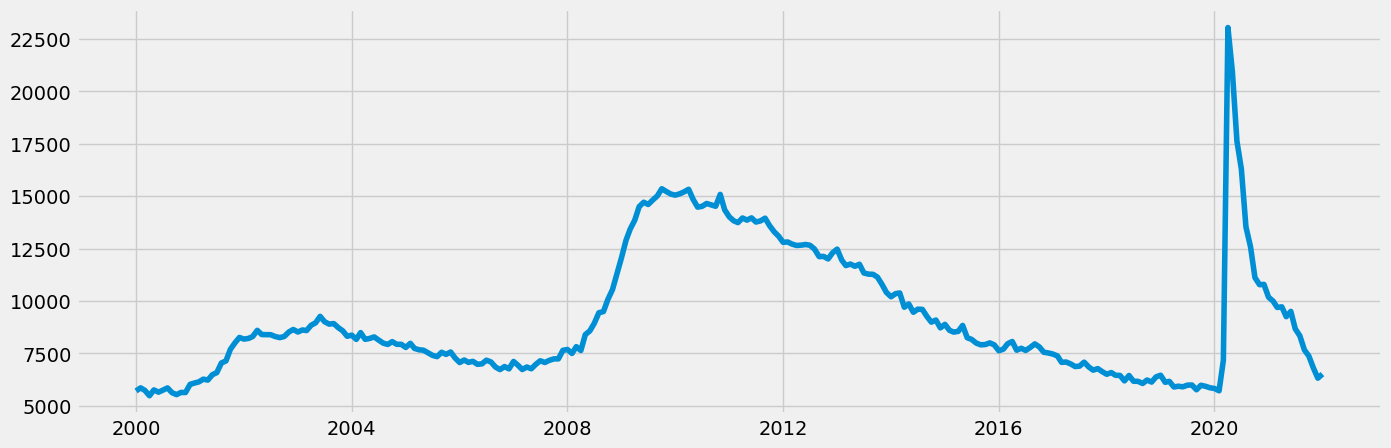

In [76]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [77]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

## 0.4 Time Series Analysis Decomposition for Unemployed

In [78]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [79]:
from pylab import rcParams # This will define a fixed size for all special charts.\n",

rcParams['figure.figsize'] = 18, 7

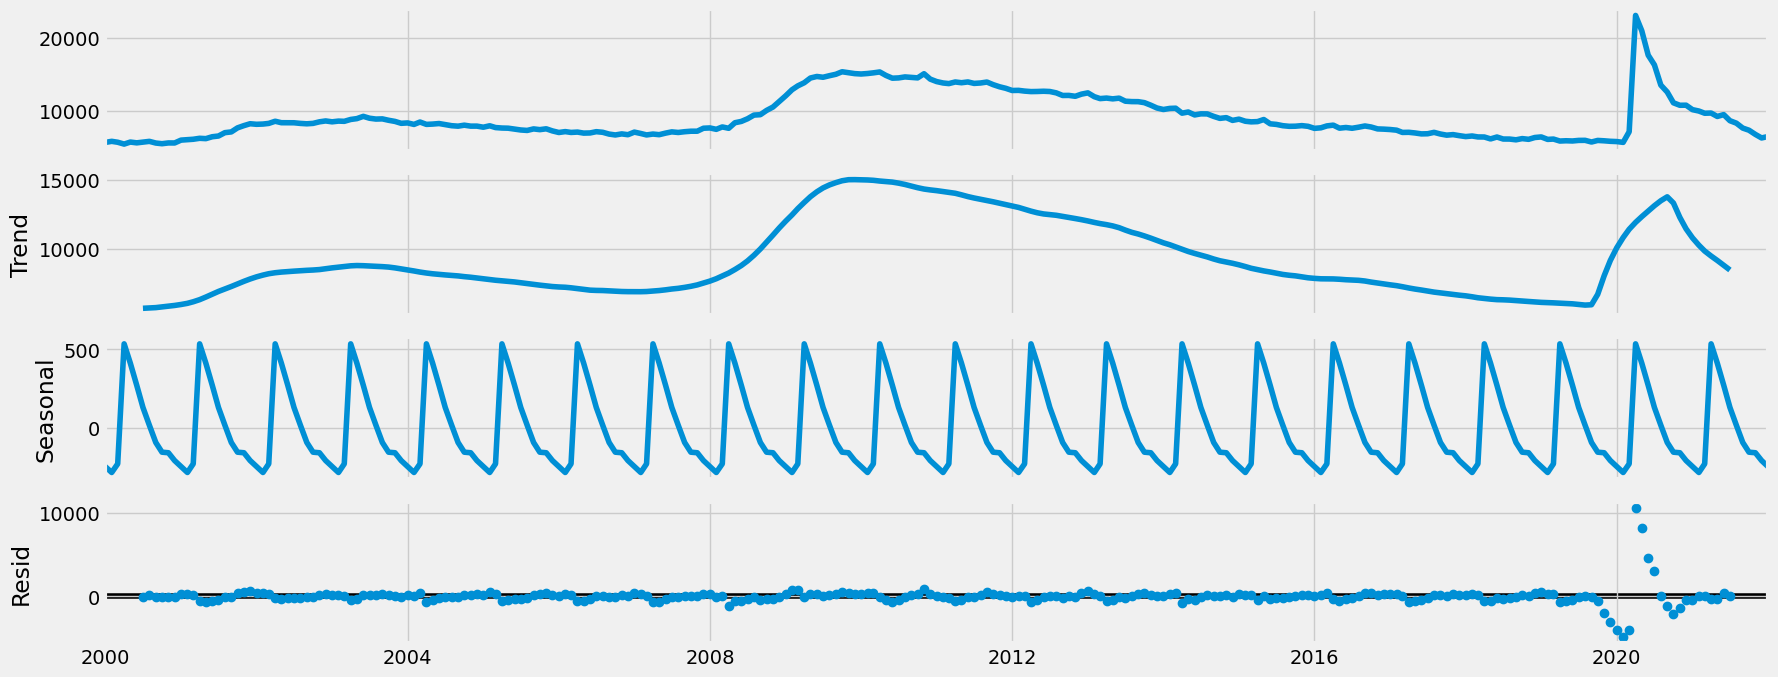

In [80]:
# Plot the separate components

decomposition.plot()
plt.show()

### Observations:
#### From the chart plotted above, we can see that there is a trend of increasing of Unemployment over the years from 2000 with a sharp spike in 2020. Most likely due to Covid-19, although seasonally, it remains consistent. 

## 0.5 Testing for Stationarity For Unemployed

In [81]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.937193
p-value                          0.041191
Number of Lags Used              0.000000
Number of Observations Used    264.000000
Critical Value (1%)             -3.455365
Critical Value (5%)             -2.872551
Critical Value (10%)            -2.572638
dtype: float64


### Observations
#### Based on these observations from the Dickey-Fuller Stationarity test, we could tentatively conclude that the unemployment data might be stationary, as the test statistic is negative and the p-value is less than 0.05. However, further analysis and additional diagnostic tests may be necessary to confirm stationarity.

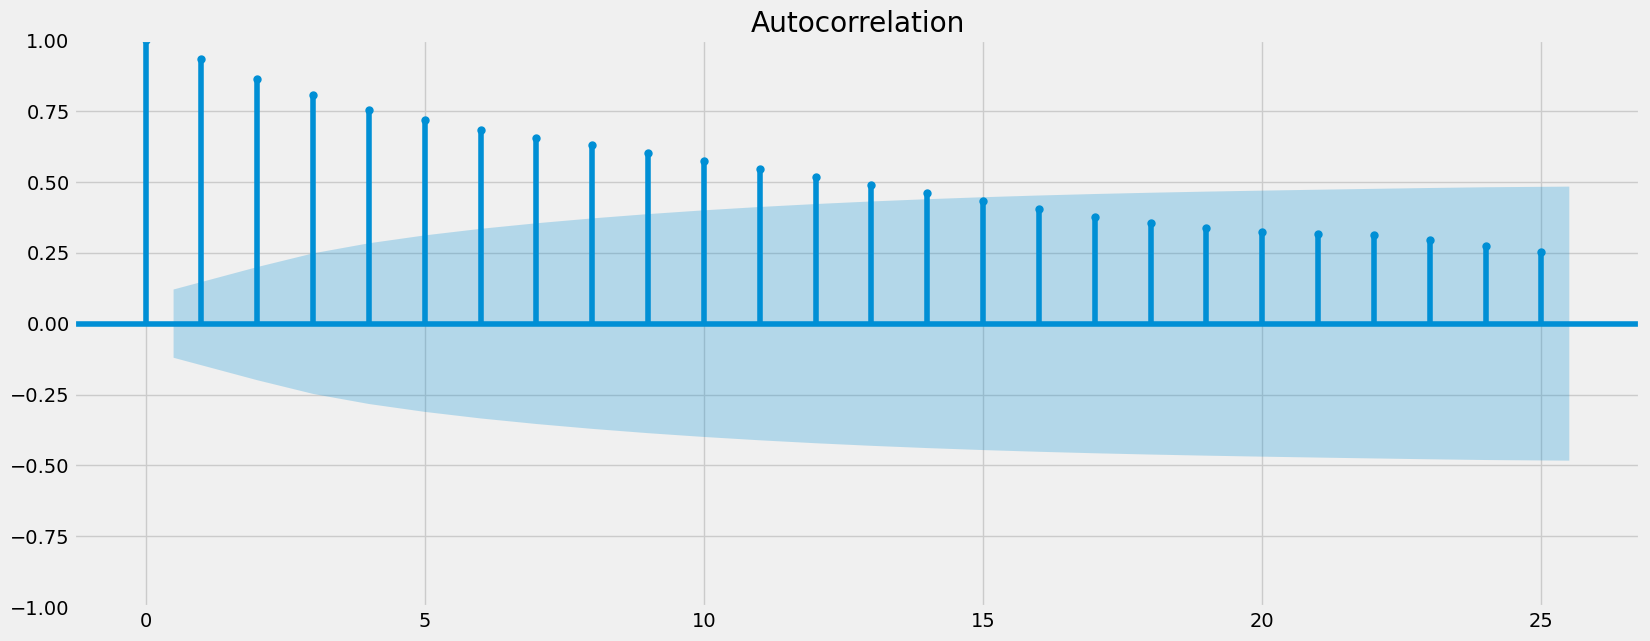

In [82]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

### Observations: The vertical lines represent the lags in the series, and the blue area displays the confidence interval. When we can see the lines go above the blue edge of the confidence interval, we can take this as meaning that the lags are significantly correlated with each other. We can see rougly over 50% have lags beyond this interval, and can deduce that this data is non-stationary.

## 0.6 Stationarizing the Federal Reserve Economic Data for Unemployed

In [83]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [84]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [85]:
data_diff.head()

Value
datetime         
2000-02-01  150.0
2000-03-01 -125.0
2000-04-01 -252.0
2000-05-01  277.0
2000-06-01 -107.0

In [86]:
data_diff.columns

Index(['Value'], dtype='object')

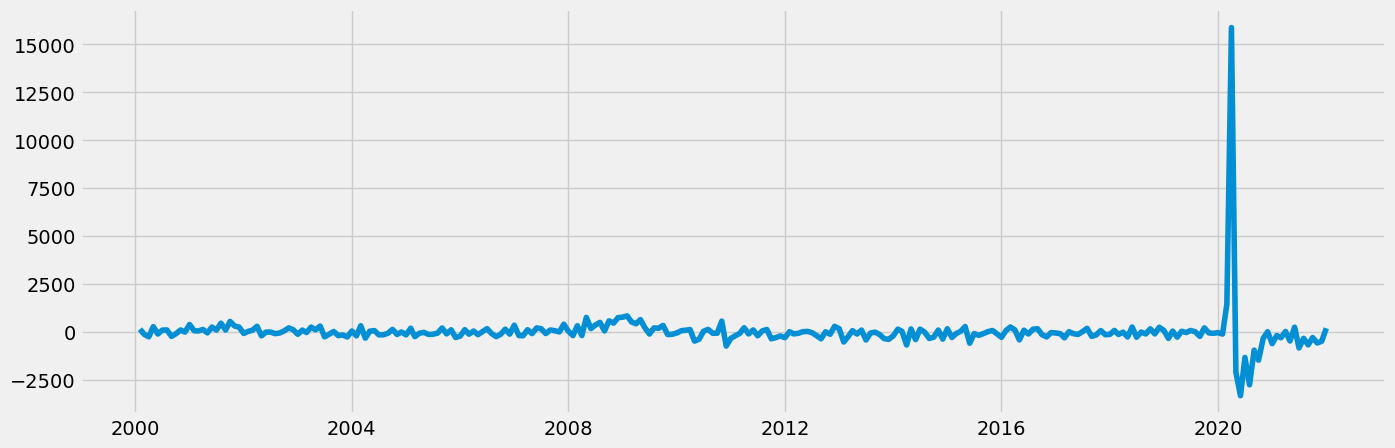

In [87]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [88]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.249513e+01
p-value                        2.887430e-23
Number of Lags Used            1.000000e+00
Number of Observations Used    2.620000e+02
Critical Value (1%)           -3.455558e+00
Critical Value (5%)           -2.872636e+00
Critical Value (10%)          -2.572683e+00
dtype: float64


### Observations:
#### After Stationarizing the Unemployment data using the Differencing method above summary, based on the Dickey-Fuller Stationarity test results, we can conclude that the unemployment data is likely stationary, as indicated by the significantly negative test statistic: The p-value associated with the test is approximately 2.8874e-23. This p-value is very close to zero, indicating strong evidence against the null hypothesis. A small p-value (typically less than 0.05) suggests rejecting the null hypothesis. This suggests that there is no unit root present in the data, supporting the hypothesis of stationarity.

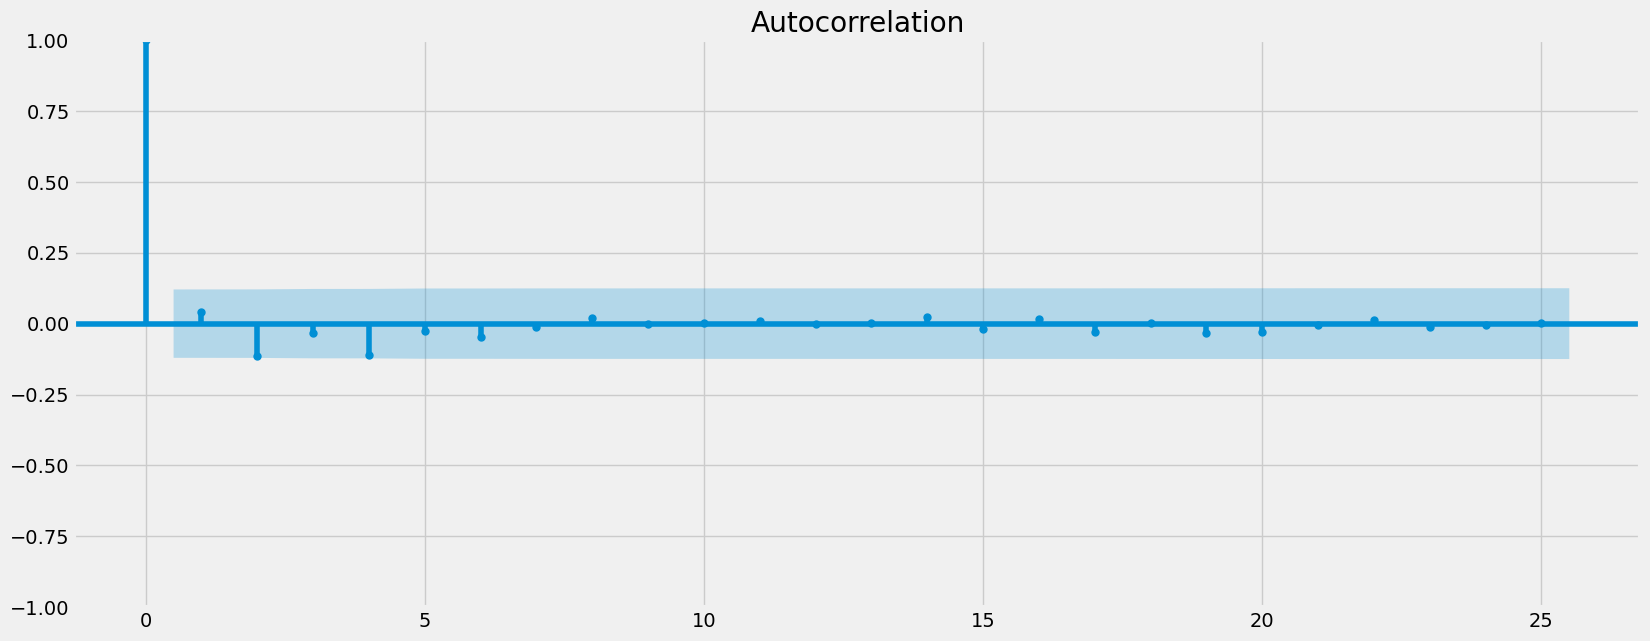

In [89]:
plot_acf(data_diff)
plt.show()

### Observations:
### The autocorrelation plot has vastly improved and we can see no lines above (or below) the blue area, it’s still not perfect however, as some touch the edge.